# Ordinal Regression - Baseline

In order to model categorical data there are two possible approaches:
- multinomial logistic regression
- ordinal regression

### Multinomial logistic regression
If the dependent variable $Y$ takes different discrete values, it can be modelled with an extension to the wide-known logistic regression model. Each category $c = c_1, ..., c_C$ is modelled via

$$ \mathbb{P}(Y_i = c_j) = \frac{\exp(\beta_K X_i)}{1 + \sum_{k=1}^K \exp(\beta_k X_i)}$$

Both sklearn and Mlib implement this approach to some extent. I.e. sklearn can handle multinomial logistic regression, but uses a lbfgs or newton-cg approach only (no sgd) with support for L2 regularization solely. In Mlib 

However, multinomial logistic regression is not always the best model to choose. Consider i.e. the case of ratings. Here, the different categories represent ordinal values implying some kind of natural order. In a multinomial logistic regression model this order is neglected. I.e. rating '5' is as good as '4' and just another category.

Links:
- <http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html>
- <http://spark.apache.org/docs/latest/mllib-linear-methods.html>
- <http://de.slideshare.net/dbtsai/2014-0620-mlor-36132297>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.linear_model import LogisticRegression
import os
import pandas as pd
import itertools
from utils import loadCovertypeData

For a description of the dataset see <https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info>

In [2]:
# Loading the dataset
cache_path = os.path.join('..', 'cache')

df = loadCovertypeData(os.path.join(cache_path, 'covtype.csv'))

In [3]:
df.head()

,Elevation,Aspect,Slope,HDHyrdo,VDHydro,HDRoadways,9amHills,NoonHills,3pmHills,HDFirePoints,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
# split into variables
respvar = ['Cover_Type']
expvar = list(set(df.columns) - set(respvar))
X = df[expvar]
Y = df[respvar]

In [5]:
#Splitting into test and training sets
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(X.shape[0]), train_size=0.7)

mask=np.ones(X.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

X_train = np.array(X[mask])
X_test = np.array(X[~mask])
Y_train = np.array(Y[mask]).flatten()
Y_test = np.array(Y[~mask]).flatten()

In [6]:
# sklearn multinomial logistic regression
# set max_iter higher to increase accuracy. Leaving to default 100 needs ~ 1min
clf = LogisticRegression(penalty='l2', multi_class='multinomial', solver='lbfgs', max_iter=200)

In [7]:
# train train set
%time clf.fit(X_train, Y_train)

CPU times: user 1min 13s, sys: 21.7 s, total: 1min 35s
Wall time: 1min 5s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)

for the sklearn implementation of the newton-cg / lbfgs solvers see https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/optimize.py

In [8]:
# store class labels
%time Y_pred = clf.predict(X_test)

CPU times: user 82.4 ms, sys: 101 ms, total: 184 ms
Wall time: 110 ms


In [9]:
# compute accuracy
accuracy = (1.0 * np.sum(Y_pred - Y_test == 0)) / Y_test.shape[0]
print 'accuracy for multinomial logistic regression:', accuracy * 100

accuracy for multinomial logistic regression: 64.4827427942


## Ordinal regression
To make up for this missing order, another model that is not yet implemented in sklearn nor Mlib is ordinal regression. The following is based mainly on Chapter9, Regression for Categorical Data, Gerhard Tutz. 

#### Model setup
Suppose we are given a response captured by a random variable $Y \in \mathbb{R}$ which is categorial with w.l.o.g. (a mapping always exists) $K$ different categories $\lbrace 1, ..., K \rbrace $ with their natural order and furthermore
$$ \mathbb{P} ( Y \in \lbrace 1, ..., K \rbrace) = 1$$

We model the ordinal regression model using binary variables $y_1, ..., y_K$ (i.e. $y_k \sim \mathrm{Ber}(p_k) \quad \quad 0 \leq p_k \leq 1$) which will be used to transform an ordinal response variable into a binary response. This way, ordinal regression can be seen as an extension to a classical, binary variable model (such as logistic regression).

For the transformation of the ordinal response to a binary one, there are three different, commonly used approaches(let $r =1, ..., K$):

- Cumulative model:
    $$ y_r = \begin{cases}1 \quad \quad Y \in \lbrace 1, ..., r \rbrace \\ 0 \quad \quad Y \in \lbrace r+1, ..., K\rbrace\end{cases}$$
- Sequential model:
    $$ y_r\vert_{\lbrace Y \geq r \rbrace} = \begin{cases}1 \quad \quad Y =r \vert Y \geq r \\ 0 \quad \quad Y >r \vert Y \geq r \end{cases}$$
- Adjacent model:
    $$ y_r\vert_{\lbrace Y \in \lbrace r, r+1\rbrace \rbrace} = \begin{cases}1 \quad \quad Y = r \vert Y \in \lbrace r, r+1\rbrace \\ 0 \quad \quad Y = r+1 \vert Y \in \lbrace r, r+1\rbrace \end{cases}$$ 
    
### Cumulative model (Threshold model)
The cumulative model (or threshold model) can be deviated assuming a latent, underlying r.v. $\tilde{Y}$ for which the actual, observed variable $Y$ can be seen as somehow rounded.

The link between those variables shall be modeled through
$$ \lbrace Y = r \rbrace = \lbrace \theta_{r-1} < \tilde{Y} \leq \theta_r \rbrace$$
for $-\infty = \theta_0 < \theta_1 < ... < \theta_{K-1} < \theta_K = +\infty$
For the latent variable a linear regression model with $x, \beta \in \mathbb{R^n}$ and a random variable $\epsilon$ is choosen:

$$ \tilde{Y} = - x^T\beta + \epsilon $$
It follows that
$$ \mathbb{P}(y_r = 1 \vert x, \beta) = \mathbb{P}(Y \leq r \vert x, \beta) = \mathbb{P}(-x^T\beta + \epsilon \leq \theta_r) = \mathbb{P}(\epsilon \leq \theta_r + x^T\beta) = F_\epsilon(\theta_r + x^T\beta)$$

$$ \implies \mathbb{P}(Y = r) = F_\epsilon(\theta_r + x^T\beta) - F_\epsilon(\theta_{r-1} + x^T\beta)$$
using the cdf $F_\epsilon$ of $\epsilon$.

In the model setup the only thing left to define is what distribution to assume/choose for $\epsilon$. Some possible choices which yield different popular models are:

- cumulative logit model: $$ \epsilon \sim \mathrm{Logistic}(0,1)$$
- probit model: $$ \epsilon \sim \mathcal{N} (0, 1)$$
- Maximum extreme-value model: $$ \epsilon \sim \mathrm{Gumbel}(0, 1)$$
- Minimum extreme-value model: $$ -\epsilon \sim \mathrm{Gumbel}(0, 1)$$

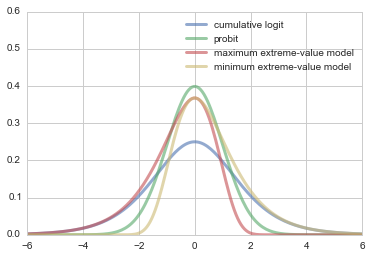

In [12]:
# pdfs for the different choices of epsilon
%matplotlib inline
from scipy.stats import logistic, norm, gumbel_l
import seaborn as sns
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4, forward=True)
x = np.linspace(-6, 6, 200)
ax.plot(x, logistic.pdf(x), c=sns.color_palette()[0], lw=3, alpha=0.6, label='cumulative logit')
ax.plot(x, norm.pdf(x), c=sns.color_palette()[1], lw=3, alpha=0.6, label='probit')
ax.plot(x, gumbel_l.pdf(x), c=sns.color_palette()[2], lw=3, alpha=0.6, label='maximum extreme-value model')
ax.plot(x, np.flipud(gumbel_l.pdf(x)), c=sns.color_palette()[4], lw=3, alpha=0.6, label='minimum extreme-value model')
plt.legend()
plt.ylim([0, 0.6])
plt.savefig('epsdf.png', dpi=150)

## Fitting the model

Assume we are given $n$ datapoints $(Y_1, X_1), ..., (Y_n, X_n)$ with $Y_i \in \lbrace 1, ..., K \rbrace, \quad X_i \in \mathbb{R}^m$ (independence assumption as usual). We simplify the fitting process, by using predefined boundaries $\theta$. Of course it is also possible to put a prior on $\theta$ and include it in the optimization approach but to do so, additional constraints need to be satisfied (i.e. $-\infty = \theta_0 < 1 < \theta_1 < 2 < ... < \theta_{K-1} < K < \theta_K = \infty$). One way to define the bounds is to use the middle, i.e.
$\theta_r = r - 0.5 \quad \text{for} \quad r = 1, ..., K-1$. 
Then, the log likelihood function of the data $\mathcal{D} = \lbrace (Y_1, X_1), ..., (Y_n, X_n) \rbrace$ is given as

$$ \mathcal{L}(\beta \; \vert \; \mathcal{D}, \theta) = \sum_{i=1}^n \log \left( F_\epsilon(\theta_{Y_i} + X_i^T \beta) - F_\epsilon(\theta_{Y_i-1} + X_i^T\beta) \right)$$

### Maximum Likelihood Estimate
this allows us to derive a Maximum Likelihood for the model

$$ \hat{\beta}_{\mathrm{MLE}} = \underset{\beta}{\operatorname{argmax}} \mathcal{L}(\beta \; \vert \; \mathcal{D}, \theta)$$
### Maximum a posteriori estimate
The MAP estimate can be derived by ignoring the normalization constant (cf. properties of an argmax) as 
$$ \hat{\beta}_{\mathrm{MAP}} = \underset{\beta}{\operatorname{argmax}} \mathcal{L}(\beta \; \vert \; \mathcal{D}, \theta) + \log f_\beta(\beta)$$

with $f_\beta$ being the pdf of the choosen prior distribution for $\beta$. Popular choices are

- Ridge regression: $\beta \sim \mathcal{N}(0, \tau I)\quad \quad$  (Gaussian prior)
- LASSO regression: $\beta_i \sim \mathrm{Laplace}(0, \tau)\quad \quad$  (Laplace prior, indep. components)

### Implementation notes
One way to solve the optimization problems is to used parallelized stochastic gradient descent as described in
<http://www.research.rutgers.edu/~lihong/pub/Zinkevich11Parallelized.pdf>. I.e. the data is distributed randomly over the nodes (the stoch. gradient shuffle step) and then per node the gradient is computed. To optimize the process, each node should node the same amount of data and the gradient is computed over all data. Thus the 'stochasticness' is done mainly in the shuffle step. After each round of computation results are aggregated by average.

#### General Gradient
$$ 
\begin{split}
\frac{\partial \mathcal{L}(\beta \;\vert\; \mathcal{D}, \theta )}{\partial \beta_j} &= \frac{\partial}{\partial \beta_j} \sum_{i=1}^n \log \left( F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right) \right) \\
&= \sum_{i=1}^n \frac{\partial}{\partial \beta_j} \log \left( F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right) \right) \\
&= \sum_{i=1}^n  \frac{\frac{\partial}{\partial \beta_j}\left[ F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right) \right]}{F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)} \\
&= \sum_{i=1}^n  \frac{f_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right)X_{i,j} - f_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)X_{i,j}}{F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)} \\
&= \sum_{i=1}^n  \frac{f_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - f_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)}{F_\epsilon\left( \theta_{Y_i}  + X_i^T\beta \right) - F_\epsilon\left( \theta_{Y_i - 1}  + X_i^T\beta \right)}X_{i,j} \\
&= \sum_{i=1}^n  g(\theta, X_i, Y_i)X_{i,j} \\
\end{split}
$$
With $X_{i,j}$ being the $j$-th component of the vector $X_i$ and $f_\epsilon$ being the density of $\epsilon$

<table>
<tr>
<td>Logistic distribution</td>
<td>$ \mathrm{Logistic}(\mu, s)$</td>
<td>$$ F(x) = \frac{1}{1 + \exp(-\frac{x-\mu}{s})}$$</td>
<td>$$ f(x) = \frac{\exp(-\frac{x-\mu}{s}}{s \left( 1 + \exp{- \frac{x-\mu}{s}}\right)^2}$$</td>
</tr>
<tr>
<td>Normal distribution</td>
<td>$ \mathcal{N}(\mu, \sigma)$</td>
<td>$$ F(x) = \Phi\left(\frac{x - \mu}{\sigma}\right)$$</td>
<td>$$ f(x) = \frac{1}{\sigma}\varphi\left(\frac{x - \mu}{\sigma}\right)$$</td>
</tr>
<tr>
<td>Gumbel distribution (Maximum extreme value)</td>
<td>$ \mathrm{Gumbel}(\mu, \beta)$</td>
<td>$$ F(x) = \exp \left( - \exp \left(- \frac{x - \mu}{\beta} \right) \right)$$</td>
<td>$$ f(x) = \frac{1}{\beta}\exp \left( - \left( \frac{x-\mu}{\beta} + \exp \left( \frac{x - \mu}{\beta}\right) \right) \right)$$</td>
</tr>
<tr>
<td>Flipped Gumbel distribution (Minimum extreme value)</td>
<td>$ -\mathrm{Gumbel}(\mu, \beta)$</td>
<td>$$ F(x) = \exp \left( - \exp \left(- \frac{-x - \mu}{\beta} \right) \right)$$</td>
<td>$$ f(x) = \frac{1}{\beta}\exp \left( - \left( \frac{-x-\mu}{\beta} + \exp \left( \frac{-x - \mu}{\beta}\right) \right) \right)$$</td>
</tr>
</table>

In [5]:
# implementation of the cumulative model (probit case)

# negative log likelihood
def nloglikelihood(X, y, theta, beta):
    llsum = 0.
    
    for i in xrange(X.shape[0]):
        llsum += np.log(norm.cdf(theta[y[i]]) - norm.cdf(theta[y[i]-1]))
    
    return -llsum

# helper function g
def gradient_g(x, yi, theta, beta):
    g = norm.pdf(theta[yi] + np.dot(x, beta)) - norm.pdf(theta[yi - 1] + np.dot(x, beta)) / \
    (norm.cdf(theta[yi] + np.dot(x, beta)) - norm.cdf(theta[yi - 1] + np.dot(x, beta)))
    return g

# negative log likelihood gradient
def nloglikelihood_gradient(X, y, theta, beta):
    grad = 0
    # more than one sample
    if len(X.shape) > 1:
        grad = np.zeros(X.shape[1])
        for i in xrange(X.shape[0]):
            grad += gradient_g(X[i, :], y[i], theta, beta)
    else:
        grad = gradient_g(X, y, theta, beta) * X
            
    return -grad
    
# stochastic gradient descent
def sgd(X, y, theta, beta0, learning_rate = 0.05, num_epochs=1):
    
    beta = beta0.copy()
    N = X.shape[0]
    for epoch in xrange(num_epochs):
        
        # randomly shuffle data
        permutation = np.random.choice(range(N), N, replace = False)
        
        # update using all ratings (minibatch size = 1)
        for i in xrange(N):
            # use here in a later version momentum
            idx = permutation[i]
            beta -= learning_rate * nloglikelihood(X[idx, :], y[idx], theta, beta)
        

### Example: Predicting the rating based on 'words'
One possibility to predict a rating is to use actual contents. This could be for a the Jester joke dataset the actual joke with its wording, or given restaurant reviews its wording (i.e. relative word count). These can be either used as binary features (if some popular word exists) or as relative / absolute count.


#### Links:
- <http://www.cambridge.org/de/academic/subjects/statistics-probability/statistical-theory-and-methods/regression-categorical-data>
- <http://fa.bianp.net/blog/2013/logistic-ordinal-regression/>
- <http://arxiv.org/pdf/1408.2327v6.pdf>
- <http://www.stat.ufl.edu/~aa/ordinal/agresti_ordinal_tutorial.pdf>
- <http://onlinelibrary.wiley.com/book/10.1002/9780470594001>

#### A versatile model

In the following, a general model is developed to model ratings. Therefore, the following variables are introduced
<table>
<tr>
<td><b>variable</b></td><td><b>meaning</b></td>
</tr>
<tr>
<td>$N$</td><td>number of data samples $n=1, ..., N$</td>
</tr>
<tr>
<td>$K$</td><td>number of latent variables per user and item</td>
</tr>
<tr>
<td>$L$</td><td>number of features describing each item</td>
</tr>
<tr>
<td>$I$</td><td>number of users, i.e. we have users $i = 1, ..., I$</td>
</tr>
<tr>
<td>$J$</td><td>number of items, i.e. $j = 1, ..., J$</td>
</tr>
<tr>
<td>$\mathcal{D}$</td><td>data matrix consisting of $N$ rows $D_n$</td>
</tr>
<tr>
<td>$\mathcal{X}$</td><td>feature data matrix consisting of $J$ rows $X_n$</td>
</tr>
<tr>
<td>$X_n$</td><td>$n$th data row, i.e $X_n = (X_{n, 1}, ..., , X_{n, L})^T$ with $X_{n,l} \in \mathbb{R}$</td>
</tr>
<tr>
<td>$D_n$</td><td>$n$th data row, i.e $D_n = (r_n, i_n, j_n)^T$ with $r_n \in \lbrace 1, ..., R\rbrace$ being a rating, $i_n, j_n$ being indices adressing a user and a item</td>
</tr>
<tr>
<td>$R$</td><td>number of ratings, i.e. each rating $r$ has to be $\in \lbrace 1, ..., R \rbrace$</td>
</tr>
<tr>
<td>$\beta$</td><td>vector describing the buckets, i.e. $-\infty = \beta_0 < 1 < \beta_1 < ... < \beta_{R-1} < R < \beta_R = \infty$</td>
</tr>
</table>

Define now the model using the ordinal regression approach with a latent variable

$$\tilde{Y}_{i, j} = - \left( u_i^Tv_j + X_j^Tw + a_i + b_j + g \right) + \epsilon$$
Let $Y_n := Y_{i_n, j_n}$

The model variables have the following definition/meaning 
<table>
<tr>
<td>$u_i \in \mathbb{R}^K$</td><td>latent variables of user $i$</td>
</tr>
<tr>
<td>$v_j \in \mathbb{R}^K$</td><td>latent variables of item $j$</td>
</tr>
<tr>
<td>$a_i \in \mathbb{R}$</td><td>bias for user $i$</td>
</tr>
<tr>
<td>$b_j \in \mathbb{R}$</td><td>bias of item $j$</td>
</tr>
<tr>
<td>$g \in \mathbb{R}$</td><td>global bias</td>
</tr>
<tr>
<td>$w \in \mathbb{R}^L$</td><td>weights for the $j$th item features</td>
</tr>
</table>

Define $\chi(i,j) := u_i^Tv_j + X_j^Tw + a_i + b_j + g$ and $\chi_n := \chi(i_n, j_n)$

The full model is parametrized via
$$\theta = \begin{pmatrix} u_1 & ... & u_I & v_1 & ... & v_J & a_1 & ... & a_I & b_1 & ... & b_J & g & w \end{pmatrix}^T$$

We can write the loglikelihood as

$$\mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) = \sum_{n=1}^N \log \left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right)$$


##### Computing the gradient

The gradient can be computed easily via the standard rules

$$
\begin{split}
\frac{\partial}{\partial u_i} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) &= \sum_{n=1}^N \frac{\partial}{\partial u_i} \log \left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right) \\
&= \sum_{n \in \lbrace n =1, ..., N \;\vert\; i_n = i\rbrace} \frac{\partial}{\partial u_i} \log \left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right)
\end{split}
$$

Let $I_i := \lbrace n =1, ..., N \;\vert\; i_n = i\rbrace, \quad J_j := \lbrace n =1, ..., N \;\vert\; j_n = j\rbrace$ , then

$$
\begin{split}
\frac{\partial}{\partial u_i} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) &= \sum_{n \in I_i}  \frac{ \frac{\partial}{\partial u_i}\left( F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n) \right)}{F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n)} \\
&= \sum_{n \in I_i}  \frac{ f_\epsilon(\beta_{Y_n} + \chi_n) - f_\epsilon(\beta_{Y_n - 1} + \chi_n)}{F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n)}\frac{\partial}{\partial u_i} \chi_n
\end{split}
$$

The structure will be always the same, so define
$$ q_n := \frac{ f_\epsilon(\beta_{Y_n} + \chi_n) - f_\epsilon(\beta_{Y_n - 1} + \chi_n)}{F_\epsilon(\beta_{Y_n} + \chi_n) - F_\epsilon(\beta_{Y_n - 1} + \chi_n)}$$

the gradient of any $\xi$ of the individual components can now be written as

$$ \frac{\partial}{\partial \xi} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) = \sum_{n=1}^N q_n \frac{\partial}{\partial \xi}\chi_n$$
(note that for many terms this is zero!)

Given

$$ \frac{\partial}{\partial u_i}\chi_n = \begin{cases} v_{j_n} \quad n \in I_i \\
0 \quad \text{else}\end{cases}$$
$$ \frac{\partial}{\partial v_j}\chi_n = \begin{cases} u_{i_n} \quad n \in J_j \\
0 \quad \text{else}\end{cases}$$
$$ \frac{\partial}{\partial a_i}\chi_n = \begin{cases} 1 \quad n \in I_i \\
0 \quad \text{else}\end{cases}$$
$$ \frac{\partial}{\partial b_j}\chi_n = \begin{cases} 1 \quad n \in J_j \\
0 \quad \text{else}\end{cases}$$

$$ \frac{\partial}{\partial w}\chi_n = X_{j_n}$$
$$\frac{\partial}{\partial g}\chi_n = 1$$

the gradient of the full model is

$$ \frac{\partial}{\partial \theta} \mathcal{L}(\theta \,\vert\, \mathcal{D}, \mathcal{X}, \beta) = \begin{pmatrix} \sum_{n \in I_1}q_n v_{j_n} & ... & \sum_{n \in I_I}q_n v_{j_n} & \sum_{n \in J_1}q_n u_{i_n} & ... & \sum_{n \in J_J}q_n u_{i_n} & \sum_{n \in I_1}q_n & ... & \sum_{n \in I_I}q_n & \sum_{n \in J_1}q_n & ... & \sum_{n \in J_J}q_n & \sum_{n =1, ..., N}q_n & \sum_{n =1, ..., N}q_nX_{j_n} \end{pmatrix}^T$$